In [89]:
pip install scikit-image

^C
Note: you may need to restart the kernel to use updated packages.


In [90]:
import keras
import skimage
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
def plot_image(images,title=None, cmap=None):
    f,axes = plt.subplots(1,len(images),sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes,images):
        ax.imshow(image,cmap)
    f.suptitle(title)

## Image Augmentation and Preprocessing

In [92]:
## path to dataset
DATASET_PATH = "flowers2"
flowers_cls = ['daisy','rose']

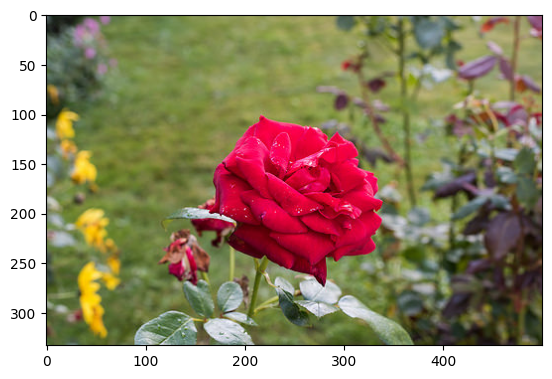

In [94]:
### getting an image from one of the two classes
flower_path = os.path.join(DATASET_PATH,flowers_cls[1],'*')
flower_path_list = glob.glob(flower_path)

## getting a random index
index = np.random.randint(0,len(flower_path_list))
image_path = flower_path_list[index] 
## Reading the image
image = io.imread(image_path)
plt.imshow(image)


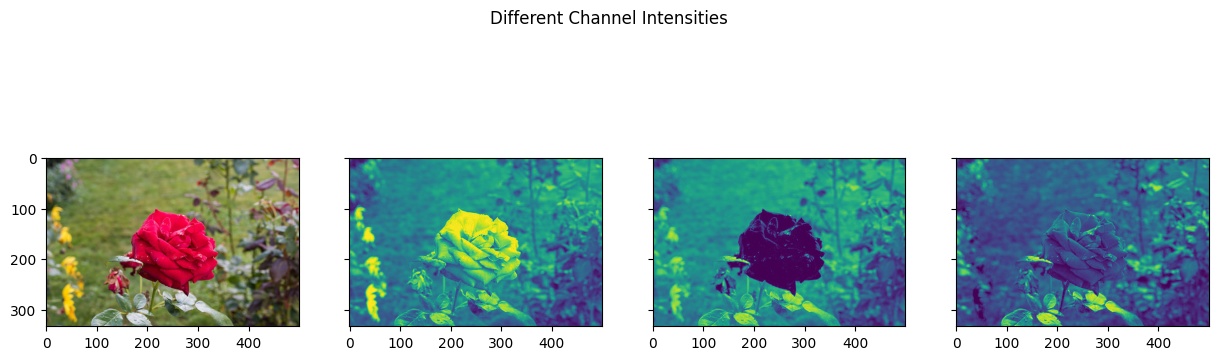

In [95]:
img_red = image[:,:,0]
img_green = image[:,:,1]
img_blue = image[:,:,2]
plot_image([image,img_red,img_green,img_blue],title="Different Channel Intensities")


### MORPHOLOGICAL TRANSFORMATIONS

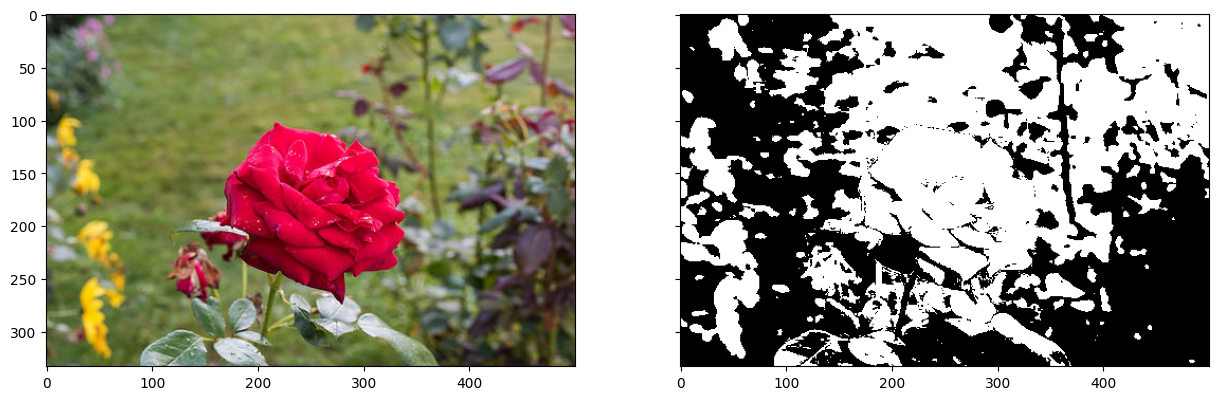

In [96]:
## Thresholding
bin_image = image[:,:,0]>125
plot_image([image,bin_image],cmap='gray')

#### Erosion, Dilation, Opening and Closing

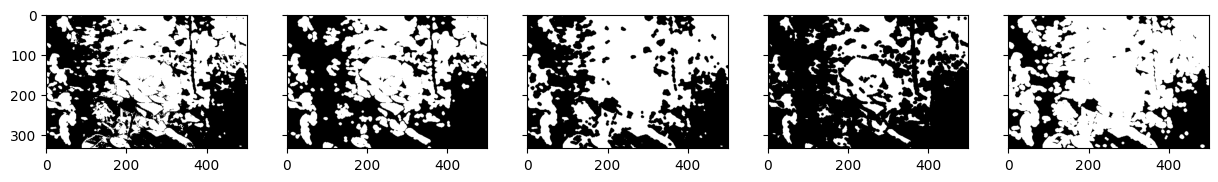

In [97]:
from skimage.morphology import binary_closing,binary_dilation,binary_erosion,binary_opening
from skimage.morphology import disk

## using a disk of radius 3
selem = disk(3)  ## structuring element

#opening and closing
open_img = binary_opening(bin_image,selem)
close_img = binary_closing(bin_image,selem)

#erosion and dilation
eroded_img = binary_erosion(bin_image,selem)
dilated_img = binary_dilation(bin_image,selem)

plot_image([bin_image,open_img,close_img,eroded_img,dilated_img],cmap='gray')

### NORMALIZATION

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


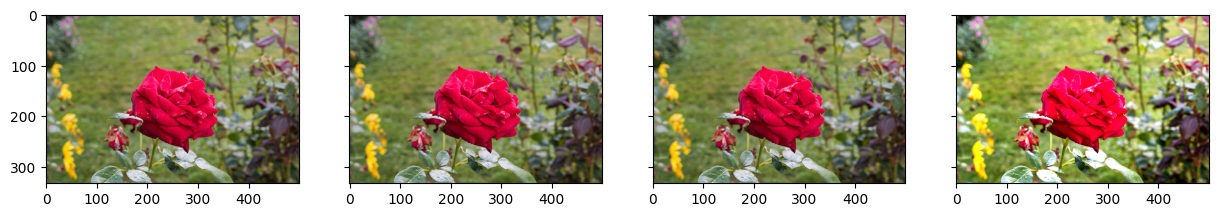

In [98]:
norm1_image = image/255  ## natural images
norm2_image = (image-np.min(image))/(np.max(image)-np.min(image))
norm3_image = (image-np.percentile(image,5))/(np.percentile(image,95) - np.percentile(image,5))   ## for outliers

plot_image([image,norm1_image,norm2_image,norm3_image])

### AUGMENTATION


1. Linear transformations
2. Affine transformations

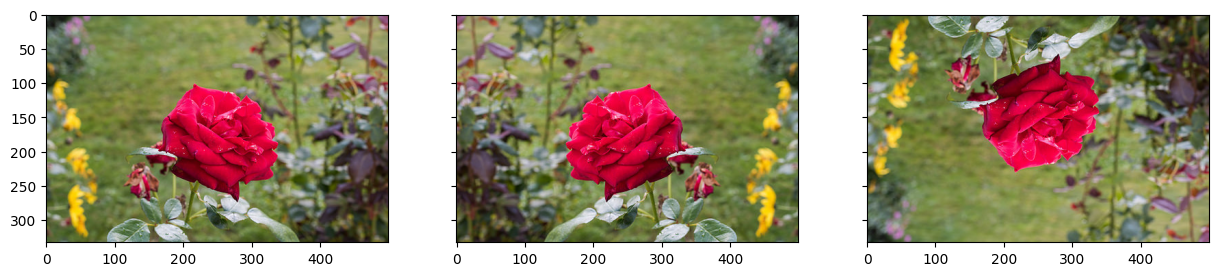

In [100]:
## flipping image left-right and upside down

image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

plot_image([image,image_flipr,image_flipud])

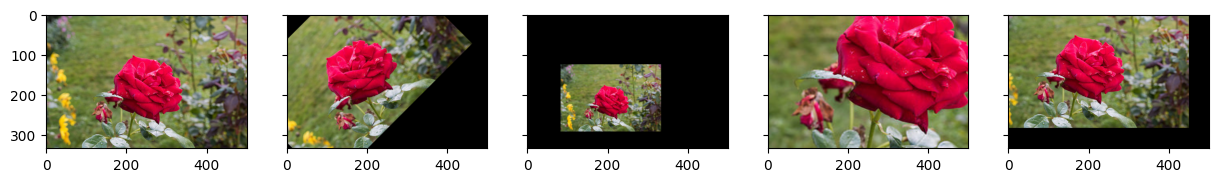

In [101]:
## Affine transformations
from skimage import transform as tf

shift_x,shift_y = image.shape[0]/2,image.shape[1]/2
matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x,-shift_y])
matrix_to_center = tf.SimilarityTransform(translation=[shift_x,shift_y])

## rotation
rot_transforms = tf.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft+rot_transforms+matrix_to_center
rot_image = tf.warp(image,rot_matrix)

# scaling
scale_transforms = tf.AffineTransform(scale=(2,2))
scale_matrix = matrix_to_topleft+scale_transforms + matrix_to_center
scale_image_zoom_out = tf.warp(image,scale_matrix)

scale_transforms  =tf.AffineTransform(scale=(0.5,0.5))
scale_matrix = matrix_to_topleft + scale_transforms+matrix_to_center
scale_image_zoom_in = tf.warp(image,scale_matrix)

## translation
translation_transforms = tf.AffineTransform(translation=(50,50))
translated_image = tf.warp(image,translation_transforms)

plot_image([image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


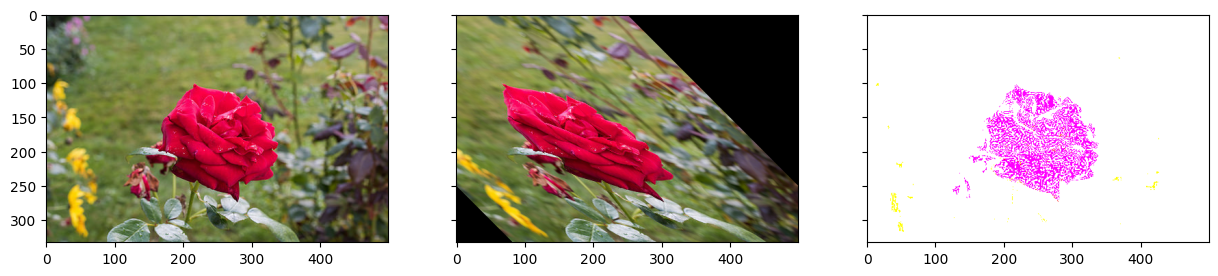

In [102]:
## shear transforms
shear_transforms = tf.AffineTransform(shear=np.deg2rad(45))
shear_matrix = matrix_to_topleft+shear_transforms+matrix_to_center
shear_image = tf.warp(image,shear_matrix)

bright_jitter= image*0.999+np.zeros_like(image)*0.001
plot_image([image,shear_image,bright_jitter])

### NETWORK BUILDING

Let's now build the network. We'll import the resnet architecture from the module `resnet.py`.

In [103]:
import resnet

# specify image size and channels
img_channels=3
img_rows=100
img_cols=100

## Number of classes
nb_classes=2

### DATA GENERATOR

In [104]:
# Custom Data Generator
import numpy as np
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

### Running Ablation Experiments

In [105]:
#Using ResNet18
model = resnet.ResnetBuilder.build_resnet_18((img_channels,img_rows,img_cols),nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])


# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = DataGenerator('train',ablation=100)
validation_generator = DataGenerator('val',ablation=100)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit(training_generator,epochs=1,validation_data = validation_generator)

C:\Users\Prince\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.4798 - loss: 1.7618 - val_accuracy: 0.5000 - val_loss: 2.3368


### OVERFITTING ON THE TRAINING DATA

In [106]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels,img_rows,img_cols),nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])


# generators
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

#fit
model.fit(training_generator,epochs=20,validation_data=validation_generator)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5787 - loss: 1.6997 - val_accuracy: 0.4948 - val_loss: 6.7122
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7313 - loss: 1.5088 - val_accuracy: 0.4948 - val_loss: 4.2639
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7107 - loss: 1.5013 - val_accuracy: 0.5208 - val_loss: 3.4239
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7624 - loss: 1.4435 - val_accuracy: 0.5885 - val_loss: 2.3130
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8104 - loss: 1.4223 - val_accuracy: 0.5885 - val_loss: 2.2410
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8036 - loss: 1.4147 - val_accuracy: 0.5938 - val_loss: 1.9037
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7895 - loss: 1.3956 - val_accuracy: 0.6510 - val_loss: 1.7030
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8466 - loss: 1.3533 - val_accuracy: 0.6979 - val_loss: 1.5908
Epoch 9/

### HYPERPARAMETER TUNING

In [107]:
## Generic way to create cusotm callback
import tensorflow as tf
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begins(self,logs={}):
        self.losses=[]

    def on_batch_end(self,batch,logs={}):
        self.losses.append(logs.get('loss'))

In [108]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

# range of learning rates to tune
hyper_parameters_for_lr = [0.1,0.01,0.001]

# callback to append loss
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.losses=[]
    
    def on_epoch_end(self,epoch,logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(learning_rate=lr,clipnorm=1.)

    # model and generators
    
    model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = DataGenerator('train', ablation=100)
    validation_generator = DataGenerator('val', ablation=100)
    model.fit(training_generator,epochs=3,validation_data=validation_generator,callbacks=[history])

    ## plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.6533 - loss: 1.6450 - val_accuracy: 0.5052 - val_loss: 11.6106
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8024 - loss: 1.3715 - val_accuracy: 0.5521 - val_loss: 7.2663
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8455 - loss: 1.3364 - val_accuracy: 0.6042 - val_loss: 4.0100


========================================   Checking for LR=0.01  ========================================
Epoch 1/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.5990 - loss: 1.6420 - val_accuracy: 0.4896 - val_loss: 1.9054
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7198 - loss: 1.5456 - val_accuracy: 0.5260 - val_loss: 2.0116
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7818 - loss: 1.4809 - val_accuracy: 0.5573 - val_loss: 1.8930


========================================   C

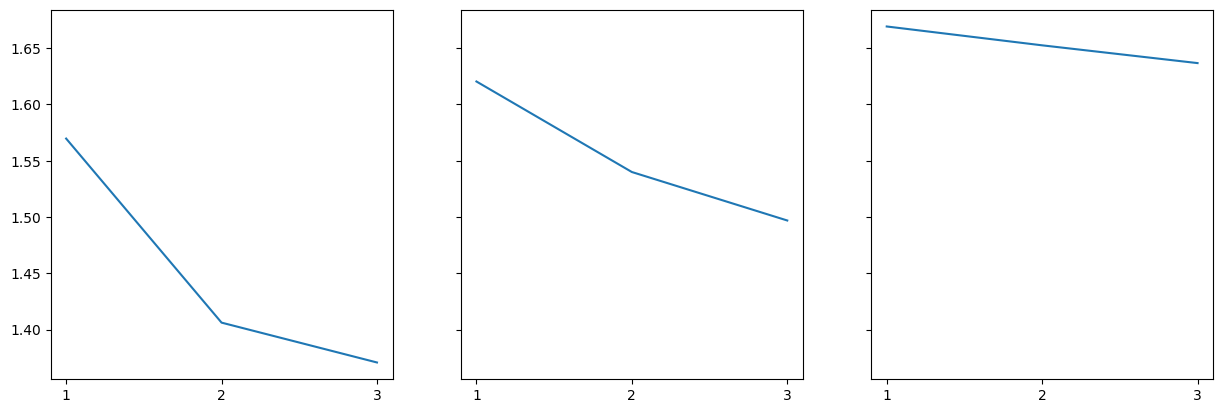

In [109]:
# plot loss history for each value of hyperparameter
f,axes = plt.subplots(1,3,sharey=True)
f.set_figwidth(15)

for i,lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(1,len(plot_data[lr])+1),plot_data[lr])
    axes[i].set_xticks(np.arange(1, len(plot_data[lr]) + 1, 1))

In [118]:
from tensorflow.keras import optimizers

class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history = []

    def on_train_begin(self, logs=None):
        # Set the initial learning rate
        self.model.optimizer.learning_rate.assign(self.base_lr)

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the new learning rate
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(new_lr)
        # Update the learning rate
        self.model.optimizer.learning_rate.assign(new_lr)

# to store loss history
history = LossHistory()
plot_data = {}

# start with lr=0.1
decay = DecayLR(base_lr=0.1)

# model
sgd = optimizers.SGD()
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[history, decay])

plot_data[lr] = decay.lr_history


Epoch 1/3


C:\Users\Prince\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5617 - loss: 1.6305 - val_accuracy: 0.4948 - val_loss: 21.1222
Epoch 2/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6907 - loss: 1.7245 - val_accuracy: 0.6094 - val_loss: 3.9363
Epoch 3/3
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8567 - loss: 1.3081 - val_accuracy: 0.6198 - val_loss: 2.5015


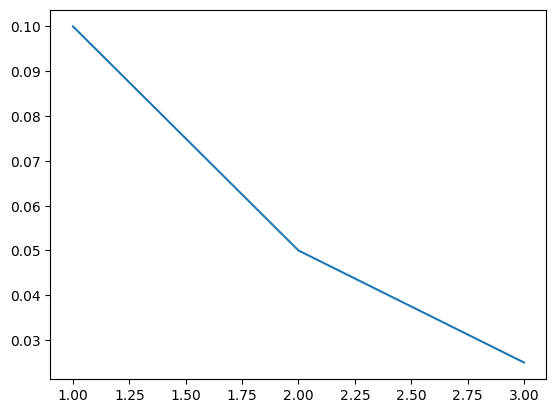

In [123]:
plt.plot(np.arange(len(decay.lr_history))+1, decay.lr_history)

### AUGMENTATION TECHNIQUE

In [124]:
# keras data generator
# help(ImageDataGenerator)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [125]:
import numpy as np
import tensorflow as tf

# data generator with augmentation
class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)
        

### METRICS TO OPTIMISE

In [138]:
from sklearn.metrics import roc_auc_score

class roc_callback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc


### FINAL RUN

In [161]:
# model
import os

# Specify the directory path
directory = 'models/'

# Update permissions to allow writing
os.chmod(directory, 0o755) 

from keras.callbacks import ModelCheckpoint
sgd = optimizers.SGD()
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=32)
validation_generator = AugmentedDataGenerator('val', ablation=32)

# checkpoint 
filepath = 'models/best_model.keras'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()

# fit
model.fit(training_generator, epochs=3, validation_data=validation_generator, callbacks=[auc_logger, history, decay, checkpoint])

Epoch 1/3


C:\Users\Prince\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5430 - loss: 1.7096 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step

Val AUC for epoch0: 0.847412109375

Epoch 1: val_auc improved from -inf to 0.84741, saving model to models/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 9s/step - accuracy: 0.5417 - loss: 1.6994 - val_accuracy: 0.5000 - val_loss: 8.2435 - val_auc: 0.8474
Epoch 2/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/stepaccuracy: 0.7734 - loss: 1.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step

Val AUC for epoch1: 0.7861328125

Epoch 2: val_auc did not improve from 0.84741
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 7s/step - accuracy: 0.7760 - loss: 1.4686 - val_accuracy: 0.5000 - val_loss: 4.5908 - val_auc: 0.7861
Epoch 3/3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/stepaccuracy: 0.7031 - loss: 1.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step

Val AUC for epoch2: 0.888671875

Epoch 3: val_auc improved from 0.84741 to 0.88867, saving model to models/best_model.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.7135 - loss:

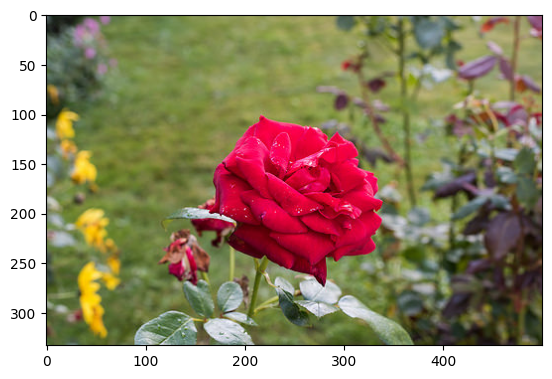

In [162]:
plt.imshow(image)

In [163]:
h, w, _ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,: ])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0., 1.]], dtype=float32)